# Replication Study
## The Effect of a Universal Child Benefit on Conceptions, Abortions, and Early Maternal Labor Supply’ by Gonzalez (2013)
### Katharina Heindl & Sean Stewart

In this report we present the results of our replication study of the paper [‘The Effect of a Universal Child Benefit on Conceptions, Abortions, and Early Maternal Labor Supply’](https://www.aeaweb.org/articles?id=10.1257/pol.5.3.160) by Gonzalez (2013). We replicate the results for fertility (conecption and abortions), and we extended the analysis to when the universal child benefit was repealed in 2010.

### Table of Contents
1. [Summary of Paper](#Summary-of-Paper)
2. [Fertility Part 1: Conceptions](#Part-1:-Conceptions)
    * [Graphs](#Graphs-for-Conceptions)
    * [Regression Table](#Regression-Table-for-Conceptions)
    * [Results](#Regression-Results-for-Conceptions)
    

3. [Fertility Part 2: Abortions](#Part-2:-Abortions)
    * [Graphs](#Graphs-for-Abortions)
    * [Regression Table](#Regression-Table-for-Abortions)
    * [Results](#Regression-Results-for-Births)
    
    
4. [Extensions: Births 2010](#Birth-Analysis-in-2010)
    * [Graphs](#Graphs-for-Births)
    * [Regression Table](#Regression-Table-for-Births)
    * [Results](#Regression-Results-for-Births)

### Summary of Paper

In her paper, Gonzalez analyzes the impact of a universal child benefit on fertility and maternal labor supply; specifically, she focuses on the introduction of a child care benefit in Spain in 2007, where a cash benefit of 2,500€ was given to the mothers immediately after giving birth. Her results show that the benefit had a statistically significant increase in fertility, partly due to a decrease in abortions. The policy also had statistically significant effects on the maternal labor supply. The results show that families who received the benefits did not increase their overall or child specific expenditures. However, mothers stayed home with their children for a longer period after giving birth. Furthermore, receiving the benefit led to a decrease in expenditures on formal daycare.  

The main experimental design used by Gonzalez is regression discontinuity. Depending on the month of birth, mothers are part of either the treatment or control group with July 2007 as the main cutoff date between the two groups. The treatment effect is given by the difference in outcomes between the treated and control groups. To control for the seasonal changes in the characteristics of women giving birth throughout the year, Gonzales includes several difference-in-differences regressions with ‘calendar month of birth’ fixed effects. 

For her analysis, Gonzalez used four data sets. For conceptions, she used a micro dataset on births in Spain between 2000 and 2009, provided by the Spanish National Statistics institute, which included data on the number of births, and on prematurity and gestation. To obtain the data on abortions, she contacted the health authorities of each of the seventeen Spanish regions, and obtained monthly data for twelve of them between 2000 and 2009. These twelve regions account for 88% of the Spanish population. For the expenditure analyses she uses a sample of the Household Budget Survey and the main labor supply analysis which is based on the large Spanish Labor Force Survey. The sample includes all households interviewed in 2008 who had a baby between October 2006 and March 2008. 


In [1]:
#Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

#Define our plot style
plt.style.use('fivethirtyeight')

# Fertility Analysis

## Part 1: Conceptions

In [2]:
#Data Import
births = pd.read_stata('C:/Users/seanm/OneDrive/Documents/school/MCs Health Econ/data_births_20110196.dta')

#Data inspection
births.head()

,mesp,year,prem,semanas
0,3.0,2000.0,1,0.0
1,1.0,2000.0,2,36.0
2,3.0,2000.0,1,37.0
3,3.0,2000.0,1,39.0
4,12.0,2000.0,1,0.0


In [3]:
#This dataset has 4 columns, and almost 5 million rows. 
births.shape

(4984066, 4)

In [4]:
#Rename the following columns to make it easier to work with
#mesp: Month_of_Birth
#year: Year_of_Birth
#prem: Prematurity
#semanas: Weeks_of_Gestation

births.rename(columns={'mesp':'Month_of_Birth','year':'Year_of_Birth','prem':'Prematurity',
                                                        'semanas':'Weeks_of_Gestation'}, inplace=True)

In [5]:
#1. Create month of birth variable, centered around July 2007
#(0 = July 2007, 1 = August 2007, etc).

births['m'] = ''
births.loc[births.Year_of_Birth==2010,'m'] = births['Month_of_Birth'] + 29
births.loc[births.Year_of_Birth==2009,'m'] = births['Month_of_Birth'] + 17
births.loc[births.Year_of_Birth==2008,'m'] = births['Month_of_Birth'] + 5
births.loc[births.Year_of_Birth==2007,'m'] = births['Month_of_Birth'] -7 #July 2007 == 0
births.loc[births.Year_of_Birth==2006,'m'] = births['Month_of_Birth'] -19
births.loc[births.Year_of_Birth==2005,'m'] = births['Month_of_Birth'] -31
births.loc[births.Year_of_Birth==2004,'m'] = births['Month_of_Birth'] -43
births.loc[births.Year_of_Birth==2003,'m'] = births['Month_of_Birth'] -55
births.loc[births.Year_of_Birth==2002,'m'] = births['Month_of_Birth'] -67
births.loc[births.Year_of_Birth==2001,'m'] = births['Month_of_Birth'] -79
births.loc[births.Year_of_Birth==2000,'m'] = births['Month_of_Birth'] -91

In [6]:
#Data inpection
births.head()

,Month_of_Birth,Year_of_Birth,Prematurity,Weeks_of_Gestation,m
0,3.0,2000.0,1,0.0,-88
1,1.0,2000.0,2,36.0,-90
2,3.0,2000.0,1,37.0,-88
3,3.0,2000.0,1,39.0,-88
4,12.0,2000.0,1,0.0,-79


In [7]:
#Create a conception variable, using both gestation and prematurity

#Conception is 9 months before birth
births['Month_of_Conception'] = births['m']-9

#Or 10 months before births if weeks of gestation is greater than 43 weeks
births.loc[((births['Weeks_of_Gestation']>43) & (births['Weeks_of_Gestation'].isnull() == False)), 'Month_of_Conception'] = births['m']-10

#Or 8 months before births if weeks of gestation is less than 39 weeks, or if there is a prematurity index of 2
births.loc[((births['Weeks_of_Gestation']<39) & (births['Weeks_of_Gestation'] != 0)) | (births['Prematurity']==2) ,'Month_of_Conception'] = births['m']-8

In [8]:
#The births dataframe had a new line for each birth. 
#To aggregate the births we will create a column for counting each birth. 
births['Number_of_Conceptions'] = 1

In [9]:
#Now we will sum the number of births by the month of conception
births_rdd = births.groupby(['Month_of_Conception']).sum()
births_rdd.reset_index(inplace=True)

In [10]:
#For our analysis, we only need two columns, 'Month_of_Conception' (which is our running variable) 
#and 'Number_of_Conceptions', so we will drop the other columns
drop_columns = ['Month_of_Birth', 'Year_of_Birth', 'Prematurity', 'Weeks_of_Gestation', 'm']
births_rdd = births_rdd.drop(drop_columns, axis=1)

#Data inspection
births_rdd.head()

,Month_of_Conception,Number_of_Conceptions
0,-100,6
1,-99,24690
2,-98,30595
3,-97,32547
4,-96,32352


In [11]:
#Create a new column that turns the 'Month_of_Conception' variable into the calendar month
#We know that Month_of_Conception == 0 = Month 7 (July)
#If we have months -100 to 33 and 0 is July that means that the following are also July: 
#Note: Author mistake number 1 ===> mislabeled some months

July = [24, 12, 0, -12, -24, -36, -48, -60, -72, -84, -96]
January = []
January[:] = [x - 6 for x in July]

births_rdd['Month'] = ''
for i in range(12): 
    for j in range(len(January)): 
        births_rdd.loc[(births_rdd['Month_of_Conception']==January[j]+i, 'Month')] = i+1

In [12]:
#Add the number of days in each month, including leap years
#Author mistake number 2 ===> Forgot to add leapyears for 2000, 2004

#Default is 31 Days
births_rdd['Days'] = 31

#Replace with 28 for February
births_rdd.loc[births_rdd['Month']==2, 'Days'] = 28

#Replace with 30 for Aprile, June, September, November
births_rdd.loc[(births_rdd['Month']==4) | 
               (births_rdd['Month']==6) | 
               (births_rdd['Month']==9) | 
               (births_rdd['Month']==11), 'Days'] = 30

#Leap years in 2000, 2004, and 2008
births_rdd.loc[(births_rdd['Month_of_Conception']== -89 )|
               (births_rdd['Month_of_Conception']== -41 )|
               (births_rdd['Month_of_Conception']==   7 )
               , 'Days'] = 29

In [13]:
#Create a post variable for when the policy was implemented
births_rdd['Post'] = 0
births_rdd.loc[births_rdd['Month_of_Conception']>=0, 'Post'] = 1

In [14]:
#Calculate the natural log of conceptions
births_rdd['ln'] = np.log(births_rdd['Number_of_Conceptions'])

In [15]:
#Stata makes it easy to create dummy variables, and their interaction terms, but Python does not.
#We will need to manually construct these in Python. 

#Create dummy variables for month. One column for each month. 
for i in range(12):
    i = i+1
    births_rdd['month_%d' % (i)] = 0
    column_name = 'month_%d' % (i)
    births_rdd.loc[births_rdd['Month']==i, column_name] = 1

In [16]:
#Create three trend variables, and their interaction terms

#Linear Trend
births_rdd['linear_trend'] = births_rdd['Month_of_Conception']
births_rdd['postXlinear'] = births_rdd['Post'] * births_rdd['linear_trend']

#Quadratic Trend
births_rdd['quad_trend'] = births_rdd['linear_trend']**2
births_rdd['postXquad'] = births_rdd['Post'] * births_rdd['quad_trend']

#Cubic Trend
births_rdd['cubic_trend'] = births_rdd['linear_trend']**3
births_rdd['postXcubic']= births_rdd['Post'] * births_rdd['cubic_trend']

In [17]:
#Data inspection
births_rdd.head()

,Month_of_Conception,Number_of_Conceptions,Month,Days,Post,ln,month_1,month_2,month_3,month_4,...,month_9,month_10,month_11,month_12,linear_trend,postXlinear,quad_trend,postXquad,cubic_trend,postXcubic
0,-100,6,3,31,0,1.791759,0,0,1,0,...,0,0,0,0,-100,0,10000,0,-1000000,0
1,-99,24690,4,30,0,10.114154,0,0,0,1,...,0,0,0,0,-99,0,9801,0,-970299,0
2,-98,30595,5,31,0,10.328592,0,0,0,0,...,0,0,0,0,-98,0,9604,0,-941192,0
3,-97,32547,6,30,0,10.390440,0,0,0,0,...,0,0,0,0,-97,0,9409,0,-912673,0
4,-96,32352,7,31,0,10.384431,0,0,0,0,...,0,0,0,0,-96,0,9216,0,-884736,0


In [18]:
#Summary Statistics
births_rdd[(births_rdd['Month_of_Conception']>-91) & (births_rdd['Month_of_Conception']<30)].describe()

,Month_of_Conception,Number_of_Conceptions,Days,Post,ln,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,linear_trend,postXlinear,quad_trend,postXquad,cubic_trend,postXcubic
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-30.500000,38020.641667,30.441667,0.250000,10.542377,0.083333,0.083333,0.083333,0.083333,0.083333,...,0.083333,0.083333,0.083333,0.083333,-30.500000,3.625000,2130.166667,71.291667,-138165.000000,1576.875000
std,34.785054,3167.548289,0.807484,0.434828,0.084545,0.277544,0.277544,0.277544,0.277544,0.277544,...,0.277544,0.277544,0.277544,0.277544,34.785054,7.657657,2379.850275,179.964954,201121.008557,4559.178611
min,-90.000000,30138.000000,28.000000,0.000000,10.313542,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,-729000.000000,0.000000
25%,-60.250000,35775.250000,30.000000,0.000000,10.485011,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-60.250000,0.000000,225.000000,0.000000,-218745.250000,0.000000
50%,-30.500000,38505.000000,31.000000,0.000000,10.558543,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-30.500000,0.000000,930.500000,0.000000,-28395.500000,0.000000
75%,-0.750000,40305.750000,31.000000,0.250000,10.604249,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.750000,0.000000,3630.250000,0.000000,-0.750000,0.000000
max,29.000000,44375.000000,31.000000,1.000000,10.700432,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,29.000000,29.000000,8100.000000,841.000000,24389.000000,24389.000000


#### Graphs for Conceptions

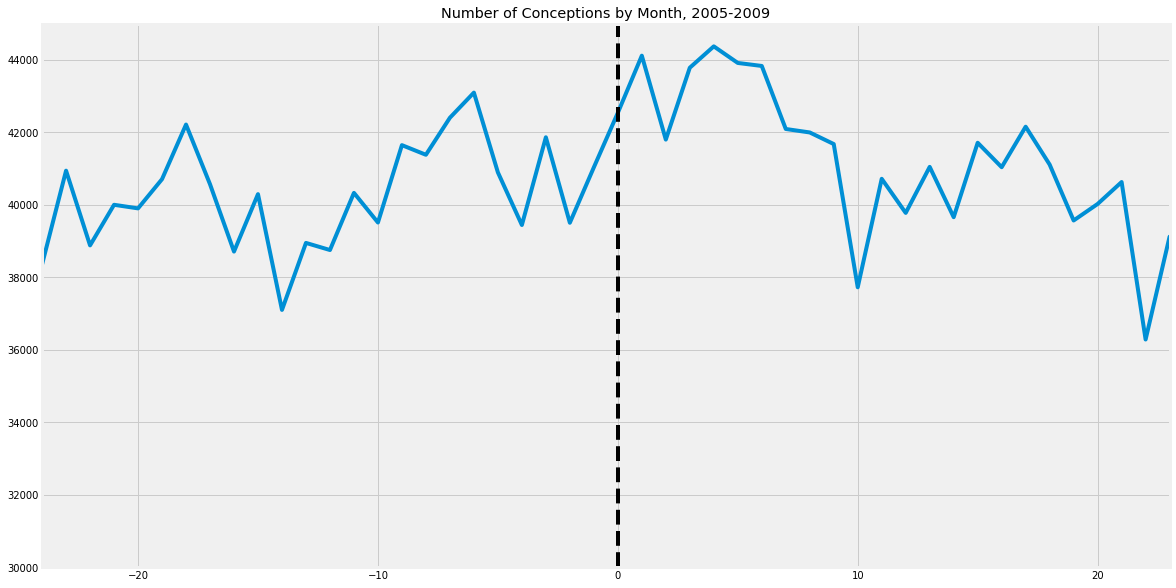

In [19]:
#Create a timeseries plot of conceptions around the cutoff
graph = births_rdd.loc[:,'Month_of_Conception':'Number_of_Conceptions']
graph.set_index(keys='Month_of_Conception', inplace=True)

#Plot
plt.figure(figsize=(18,10))
plt.plot(graph)
axes = plt.gca()
axes.set_xlim([-24,23])
axes.set_ylim([30000,45000])
plt.axvline(x=0,color="black", linestyle="--")
plt.title('Number of Conceptions by Month, 2005-2009')
plt.show()

In [20]:
#Visualize the discontinuity using a scatterplot with linear trends. 

#Define a function so we can reuse this code later
def rdd_graph(x_axis,y_axis, title):
    
    #Scatterplot
    window_y = y_axis.loc[(x_axis>-25) & (x_axis<24)]
    window_x = x_axis.loc[(x_axis>-25) & (x_axis<24)]

    #Trendline after the cutoff
    window1_y = y_axis.loc[(x_axis>-1) & (x_axis<24)]
    window1_x = x_axis.loc[(x_axis>-1) & (x_axis<24)]

    #Trendline before the cutoff
    window2_y = y_axis.loc[(x_axis>-25) & (x_axis<1)]
    window2_x = x_axis.loc[(x_axis>-25) & (x_axis<1)]

    #Calculate linear fit lines
    x1 = sm.add_constant(window1_x)
    result1 = sm.OLS(window1_y, x1).fit()
    x2 = sm.add_constant(window2_x)
    result2 = sm.OLS(window2_y, x2).fit()

    #Plot the graph
    plt.figure(figsize=(18,10))
    plt.scatter(window_x,window_y)
    plt.plot(window1_x, result1.predict(), color="xkcd:red orange")
    plt.plot(window2_x, result2.predict(), color="xkcd:red orange")
    plt.axvline(x=0,color="black", linestyle="--")
    plt.title(title, fontsize="18")

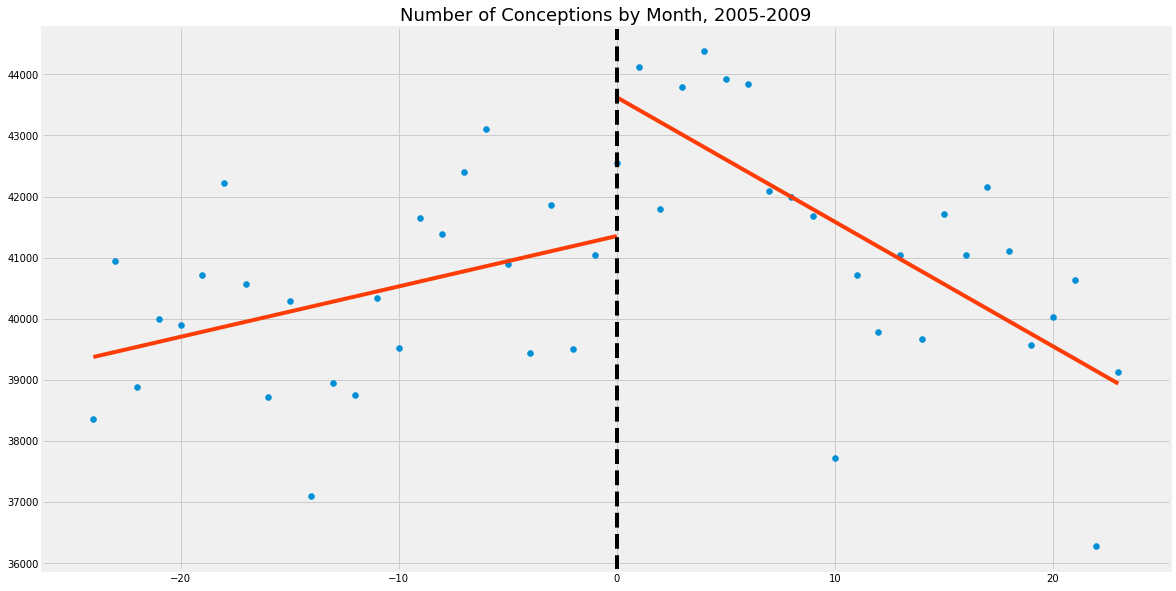

In [21]:
rdd_graph(births_rdd['Month_of_Conception'], births_rdd['Number_of_Conceptions'], 'Number of Conceptions by Month, 2005-2009')

The above two graphs take a closer look at the variable ‘Number of Conceptions by Month’. The first graph shows the number of conceptions by month in the years 2005 – 2009. In the second graph, the regression discontinuity design can be observed and a clear jump around the cutoff can be seen. This shows the influence of the policy on conceptions.    

In [22]:
#To make doing the regressions easier, we wrote a function to assist us. 
#All the function needs is the start/end periods, and which dummy variables we need.
#I defined a new function for each of the three analyses, in the future I would write a more general function

def regression_births(start_date, end_date, linear_trend, quad_trend, cubic_trend, month_dummies):
    
    data = births_rdd.loc[(births_rdd['Month_of_Conception']>start_date) & (births_rdd['Month_of_Conception']<end_date)]
    
    x = ['Post', 'Days']
    y = data['ln']
    
    if linear_trend == True:
        lt = ['linear_trend', 'postXlinear']
        x += lt
    
    if quad_trend == True:
        qt = ['quad_trend', 'postXquad']
        x += qt
        
    if cubic_trend == True:
        ct = ['cubic_trend', 'postXcubic']
        x += ct
        
    if month_dummies == True:
        md = ['month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
                'month_10','month_11', 'month_12']
        x += md
        
    x = sm.add_constant(data[x])
    model = sm.OLS(y,x).fit(cov_type='HC1')
    
    return model

#### Regression Table for Conceptions

In [23]:
#Example regression, and full output. 

#18 month with linear trend
month_dummies = False
linear_trend = True
quad_trend = False
cubic_trend = False

print(regression_births(-10, 9, linear_trend, quad_trend, cubic_trend, month_dummies).summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     5.891
Date:                Mon, 01 Apr 2019   Prob (F-statistic):            0.00625
Time:                        12:40:52   Log-Likelihood:                 42.248
No. Observations:                  18   AIC:                            -74.50
Df Residuals:                      13   BIC:                            -70.04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.4923      0.179     58.458   

C:\Users\seanm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [24]:
#The paper runs 8 regression, so we wrote a function that will run each regression, 
#and organize the results into a table. 

#List regression parameters
regression_parameters = pd.DataFrame()

#(Start Period, End Period, Linear Trend, Quadatic Trend, Cubic Trend, Month Controls)
parameters  =[[-91, 30, True, True, True, False], 
             [-31,30, True,True, False, False],
             [-13,12,True,True, False, False],
             [-10,9,True,False, False, False],
             [-4,3,False,False,False, False],
             [-91,30, True,True, True, True],
             [-67,30, True,True, False, True],
             [-31,30,True,True, False, True]]

#Name the columns of the table
regression_parameters = pd.DataFrame(parameters, columns=['Starting Period', 
                                                          'Ending Period', 'Linear Trend', 'Quadratic Trend', 
                                                          'Cubic Trend', 'Month Controls'])

#Name the rows of the table
regression_results = pd.DataFrame(columns=['Coefficent', 'Standard Error', 'p-value'])

In [25]:
#Run the regressions, and organize the results in a table
for i in range(8):
    x = regression_parameters.iloc[i].tolist()
    results = pd.Series([regression_births(*x).params.Post, 
               regression_births(*x).bse.Post, 
               regression_births(*x).pvalues.Post], index=regression_results.columns)
    regression_results = regression_results.append(results, ignore_index=True)

regression_results = pd.concat([regression_results.T, regression_parameters.T], ignore_index=False)
regression_results = regression_results.rename(columns={0:'RDD (120 Months)',1:'RDD (60 Months)',2:'RDD (24 Months)',
                                                        3:'RDD (18 Months)', 4:'RDD (6 Months)',
                                                        5:'DID (120 Months)',6:'DID (84 Months)',7:'DID (60 Months)'})

#### Regression Results for Conceptions

In [26]:
regression_results

,RDD (120 Months),RDD (60 Months),RDD (24 Months),RDD (18 Months),RDD (6 Months),DID (120 Months),DID (84 Months),DID (60 Months)
Coefficent,0.0530654,0.0694597,0.0851851,0.0750223,0.0503363,0.0495223,0.0539217,0.0526662
Standard Error,0.0219492,0.0250128,0.0359015,0.0284876,0.0313647,0.0102652,0.00875373,0.0135861
p-value,0.015621,0.0054869,0.0176566,0.00845078,0.108523,1.40508e-06,7.2813e-10,0.000105987
Starting Period,-91,-31,-13,-10,-4,-91,-67,-31
Ending Period,30,30,12,9,3,30,30,30
Linear Trend,True,True,True,True,False,True,True,True
Quadratic Trend,True,True,True,False,False,True,True,True
Cubic Trend,True,False,False,False,False,True,False,False
Month Controls,False,False,False,False,False,True,True,True


The results indicate that the universal child benefit had a statistically significant impact on the number of conceptions and abortions around the cut off. Conceptions increased between 4.9% to 7.5%. These results remain robust even as the author extends the bandwidth window, adds trend variables, and month fixed effects.  The only results that are not significant are those for conceptions using a 6-month bandwidth, and this could be due to the length of time needed for conception to occur. 

### Part 2: Abortions

In [27]:
#Import Data
abortions = pd.read_stata('C:/Users/seanm/OneDrive/Documents/school/MCs Health Econ/data_abortions_20110196.dta')

#Data inspection
abortions.head()

,year,month,n_ive_and,n_ive_val,n_ive_rioja,n_ive_cat,n_ive_can,n_ive_mad,n_ive_gal,n_ive_bal,n_ive_pv,n_ive_castlm,n_ive_ast,n_ive_arag
0,1999,1,812.0,NaN,NaN,NaN,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999,2,803.0,NaN,NaN,NaN,206.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999,3,916.0,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999,4,763.0,NaN,NaN,NaN,229.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999,5,769.0,NaN,NaN,NaN,202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Each 'n_ive' column is a different region in Spain. 
#Not all regions are represented, but the regions provided account for 88% of abortions in Spain
#First, we will replace 'NaN' values with 0
abortions.fillna(0, inplace=True)

In [29]:
#Next we will sum abortions across each region
abortions['Number_of_Abortions'] = abortions.iloc[:,2:14 ].sum(axis=1)

In [30]:
#Create a new month variable, and center it around July 2007
abortions['m'] = abortions.index+1
abortions['m'] = abortions['m'] - 103

In [31]:
#Create a new days column
abortions['Days'] = 31

abortions.loc[(abortions['month']==4) | (abortions['month']==6) | 
              (abortions['month']==9) | (abortions['month']==11), 'Days'] = 30

abortions.loc[(abortions['month']==2), 'Days']=28

#Leapyears in 2000, 2004, and 2008
abortions.loc[(abortions['month']==2) & 
              ((abortions['year']==2000) | 
               (abortions['year']==2004) | 
               (abortions['year']==2008)), 'Days'] = 29

In [32]:
#Generate natural log of abortions
abortions['ln'] = np.log(abortions['Number_of_Abortions'])

In [33]:
#Create a post variable
abortions['Post'] = 0
abortions.loc[abortions['m']>=0, 'Post'] = 1

In [34]:
#Create three trend dummies, and their interaction terms

#Linear Trend
abortions['linear_trend'] = abortions['m']
abortions['postXlinear'] = abortions['Post'] * abortions['linear_trend']

#Quadratic Trend
abortions['quad_trend'] = abortions['linear_trend']**2
abortions['postXquad'] =  abortions['Post'] * abortions['quad_trend']

#Cubic Trend
abortions['cubic_trend'] = abortions['linear_trend']**3
abortions['postXcubic'] =  abortions['Post'] * abortions['cubic_trend']

In [35]:
#Month interaction term
for i in range(12):
    i = i+1
    abortions['month_%d' % (i)] = 0
    column_name = 'month_%d' % (i)
    abortions.loc[abortions['month']==i, column_name] = 1

In [36]:
#Drop the columns we don't need
drop_columns = ['n_ive_and', 'n_ive_val', 'n_ive_rioja', 'n_ive_cat', 'n_ive_can', 'n_ive_mad', 'n_ive_gal', 'n_ive_bal', 'n_ive_pv', 'n_ive_castlm', 'n_ive_ast', 'n_ive_arag']
abortions = abortions.drop(drop_columns, axis=1)

In [37]:
#Data inspection
abortions.head()

,year,month,Number_of_Abortions,m,Days,ln,Post,linear_trend,postXlinear,quad_trend,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1999,1,1015.0,-102,31,6.922644,0,-102,0,10404,...,0,0,0,0,0,0,0,0,0,0
1,1999,2,1009.0,-101,28,6.916715,0,-101,0,10201,...,0,0,0,0,0,0,0,0,0,0
2,1999,3,1172.0,-100,31,7.066467,0,-100,0,10000,...,1,0,0,0,0,0,0,0,0,0
3,1999,4,992.0,-99,30,6.899723,0,-99,0,9801,...,0,1,0,0,0,0,0,0,0,0
4,1999,5,971.0,-98,31,6.878326,0,-98,0,9604,...,0,0,1,0,0,0,0,0,0,0


In [38]:
#Summary statistics
abortions.describe()

,year,month,Number_of_Abortions,m,Days,ln,Post,linear_trend,postXlinear,quad_trend,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,2004.500000,6.500000,5855.125000,-30.500000,30.437500,8.537367,0.291667,-30.500000,5.979167,2658.166667,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
std,3.464102,3.464102,2315.818229,41.713307,0.816943,0.620675,0.456116,41.713307,11.427160,2979.840935,...,0.277350,0.277350,0.277350,0.277350,0.277350,0.277350,0.277350,0.277350,0.277350,0.277350
min,1999.000000,1.000000,905.000000,-102.000000,28.000000,6.807935,0.000000,-102.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2001.750000,3.750000,4950.250000,-66.250000,30.000000,8.507192,0.000000,-66.250000,0.000000,324.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2004.500000,6.500000,6171.500000,-30.500000,31.000000,8.727686,0.000000,-30.500000,0.000000,1296.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.250000,9.250000,7500.750000,5.250000,31.000000,8.922754,1.000000,5.250000,5.250000,4389.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2010.000000,12.000000,9553.000000,41.000000,31.000000,9.164611,1.000000,41.000000,41.000000,10404.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Graphs for Abortions

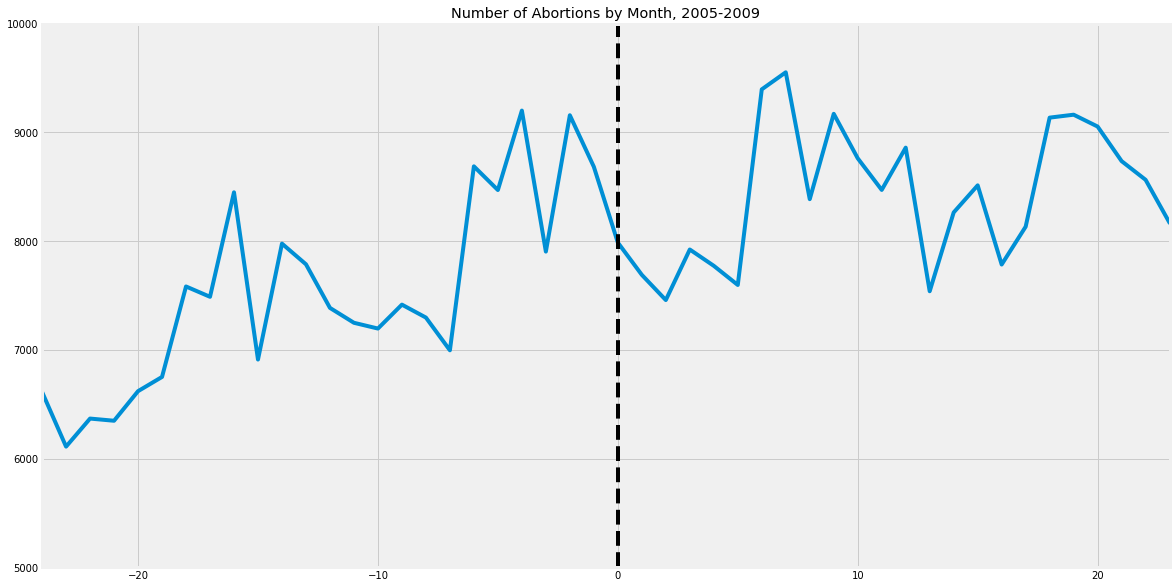

In [39]:
plt.figure(figsize=(18,10))
data = abortions.set_index(keys='m')
plt.plot(data['Number_of_Abortions'])
axes = plt.gca()
axes.set_xlim([-24,23])
axes.set_ylim([5000,10000])
plt.axvline(x=0,color="black", linestyle="--")
plt.title('Number of Abortions by Month, 2005-2009')
plt.show()

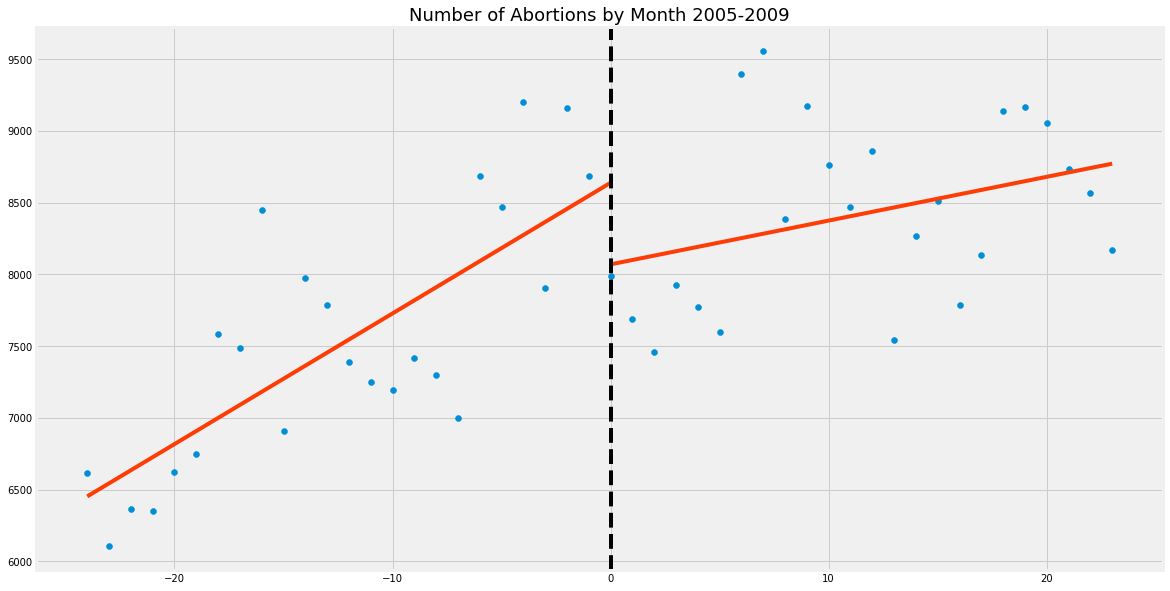

In [40]:
rdd_graph(abortions['m'], abortions['Number_of_Abortions'], "Number of Abortions by Month 2005-2009")

The above two graphs take a closer look at the variable ‘Number of Abortions by Month’. The first graph shows the number of abortions by month in the years 2005 – 2009. In the second graph, the regression discontinuity design can be observed and a clear jump around the cutoff can be seen. This shows the influence of the policy on abortions.    

In [41]:
def regression_abortions(start_date, end_date, linear_trend, quad_trend, cubic_trend, month_dummies):
    
    data = abortions.loc[(abortions['m']>start_date) & (abortions['m']<end_date)]
    
    x=['Post', 'Days']
    
    y = data['ln']
    
    if linear_trend == True:
        lt = ['linear_trend', 'postXlinear']
        x += lt
    
    if quad_trend == True:
        qt = ['quad_trend', 'postXquad']
        x += qt
        
    if cubic_trend == True:
        ct = ['cubic_trend', 'postXcubic']
        x += ct
        
    if month_dummies == True:
        md = ['month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
                'month_10','month_11', 'month_12']
        x += md
        
    x = sm.add_constant(data[x])
    
    model = sm.OLS(y,x).fit(cov_type='HC1')
    
    return model

#### Regression Table for Abortions

In [42]:
linear_trend = True
quad_trend = True
cubic_trend = False
month_dummies = False

print(regression_abortions(-13, 12, linear_trend, quad_trend, cubic_trend, month_dummies).summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     8.752
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           0.000193
Time:                        12:40:54   Log-Likelihood:                 32.961
No. Observations:                  24   AIC:                            -51.92
Df Residuals:                      17   BIC:                            -43.68
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.2040      0.676     13.607   

In [43]:
#List regression parameters
regression_parameters_abortions = pd.DataFrame

#(Start Period, End Period, Linear Trend, Quadatic Trend, Cubic Trend, Month Controls)
parameters  =[[-91, 30, True, True, True, False], 
             [-31,30, True,True, False, False],
             [-13,12,True,True, False, False],
             [-10,9,True,False, False, False],
             [-4,3,False,False,False, False],
             [-91,30, True,True, True, True],
             [-67,30, True,True, False, True],
             [-31,30,True,True, False, True]]

regression_parameters_abortions = pd.DataFrame(parameters, columns=['Starting Period', 'Ending Period', 
                                                                    'Linear Trend', 'Quadratic Trend', 
                                                                    'Cubic Trend', 'Month Controls'])

regression_results_abortions = pd.DataFrame(columns=['Coefficent', 'Standard Error', 'p-value'])

In [44]:
for i in range(8):
    x = regression_parameters_abortions.iloc[i].tolist()
    results = pd.Series([regression_abortions(*x).params.Post, 
               regression_abortions(*x).bse.Post, 
               regression_abortions(*x).pvalues.Post], index=regression_results_abortions.columns)
    regression_results_abortions = regression_results_abortions.append(results, ignore_index=True)

In [45]:
regression_results_abortions = pd.concat([regression_results_abortions.T, regression_parameters_abortions.T], ignore_index=False)
regression_results_abortions = regression_results_abortions.rename(columns={0:'RDD (120 Months)',1:'RDD (60 Months)',
                                                                            2:'RDD (24 Months)',3:'RDD (18 Months)',4:'RDD (6 Months)',
                                                                            5:'DID (120 Months)',6:'DID (84 Months)',7:'DID (60 Months)'})


#### Regression Results for Abortions

In [46]:
regression_results_abortions

,RDD (120 Months),RDD (60 Months),RDD (24 Months),RDD (18 Months),RDD (6 Months),DID (120 Months),DID (84 Months),DID (60 Months)
Coefficent,-0.124794,-0.172954,-0.218713,-0.216493,-0.130449,-0.0751306,-0.0610445,-0.0648959
Standard Error,0.0426989,0.0503841,0.0780549,0.0612947,0.0310427,0.0267758,0.0253806,0.0365535
p-value,0.00347054,0.000597581,0.00507797,0.000412419,2.64277e-05,0.00501745,0.0161651,0.0758369
Starting Period,-91,-31,-13,-10,-4,-91,-67,-31
Ending Period,30,30,12,9,3,30,30,30
Linear Trend,True,True,True,True,False,True,True,True
Quadratic Trend,True,True,True,False,False,True,True,True
Cubic Trend,True,False,False,False,False,True,False,False
Month Controls,False,False,False,False,False,True,True,True


The results indicate that the universal child benefit had a statistically significant impact on the number of abortions around the cut off. Abortions decreased between 6% to 21%. These results remain robust even as the author extends the bandwidth window, adds trend variables, and month fixed effects.

# Birth Analysis in 2010

At the end of her paper, Gonzalez states “… the Spanish child benefit was removed in May 2010 (in effect for births starting January 2011), as part of broader budget cuts. It will be interesting to see if the repeal of the benefit reverses the effects observed after its introduction.” (Gonzalez 2013:184) We took this statement as a motivation to conduct further analysis to look at the effect of the policy being abolished in 2010. 

Our goal was to match Gonzalez’s analysis of fertility as closely as possible. We found publicly available data on monthly births in Spain, but we did not find data on monthly abortions (only yearly). So we proceeded with analysis of births, and not abortions. Additionally, the births dataset differed from the one used in the paper in that it only included the total monthly number of births, and no information about prematurity, and gestation. Due to this we decided to change the research question from looking at conceptions around the policy announcement, to whether there was a change in the number of births 9 months after the announcement. This means that our cutoff date was not May 2010, when the policy was announced, but February 2011, 9 months after the policy announcement. 

Before we conducted an analysis, we first had to clean and construct the dataset.

In [47]:
#Import data
births_updated = pd.read_csv('C:/Users/seanm/OneDrive/Documents/school/MCs Health Econ/births_final_spain.csv')

#Data inspection
births_updated.head(14)

,Country or Area,Year,Area,Month,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Spain,2016,Total,Total,Data tabulated by year of occurrence,"Final figure, complete",2018,408734,NaN
1,Spain,2016,Total,January,Data tabulated by year of occurrence,"Final figure, complete",2018,34333,NaN
2,Spain,2016,Total,February,Data tabulated by year of occurrence,"Final figure, complete",2018,31959,NaN
3,Spain,2016,Total,March,Data tabulated by year of occurrence,"Final figure, complete",2018,34140,NaN
4,Spain,2016,Total,April,Data tabulated by year of occurrence,"Final figure, complete",2018,31613,NaN
5,Spain,2016,Total,May,Data tabulated by year of occurrence,"Final figure, complete",2018,33288,NaN
6,Spain,2016,Total,June,Data tabulated by year of occurrence,"Final figure, complete",2018,34054,NaN
7,Spain,2016,Total,July,Data tabulated by year of occurrence,"Final figure, complete",2018,35653,NaN
8,Spain,2016,Total,August,Data tabulated by year of occurrence,"Final figure, complete",2018,36041,NaN
9,Spain,2016,Total,September,Data tabulated by year of occurrence,"Final figure, complete",2018,35996,NaN


In [48]:
#Notice the data is not structured in chronological order:  
#The years are in ascending order, but the months are in descending order. 
#For example, the data jumps from December 2016, to January 2015. 
#Also notice that each year has 13 data points, each month and a 'Total'

In [49]:
#Drop the 'Total' and 'Unknown' rows. This leaves just the monthly data. 
births_updated = births_updated.loc[(births_updated['Month'] != 'Total') & (births_updated['Month'] != 'Unknown')]

In [50]:
#We do not need several columns, lets drop them. 
drop_columns = ['Country or Area', 'Area', 'Record Type',
       'Reliability', 'Source Year', 'Value Footnotes']

births_updated = births_updated.drop(drop_columns, axis=1)

In [51]:
#Next, we will drop any data before 1996. 
births_updated = births_updated.loc[births_updated['Year']>1995]
births_updated.rename(columns ={'Value' : 'Number_of_Births'}, inplace=True)

In [52]:
births_updated.describe()

,Year,Number_of_Births
count,252.000000,252.000000
mean,2006.000000,36220.710317
std,6.067351,4022.762548
min,1996.000000,27517.000000
25%,2001.000000,33222.250000
50%,2006.000000,36146.000000
75%,2011.000000,39512.750000
max,2016.000000,45362.000000


In [53]:
#Convert the Month column from a name to number
births_updated.loc[births_updated['Month']=='January', 'Month'] = 1
births_updated.loc[births_updated['Month']=='February', 'Month'] = 2
births_updated.loc[births_updated['Month']=='March', 'Month'] = 3
births_updated.loc[births_updated['Month']=='April', 'Month'] = 4
births_updated.loc[births_updated['Month']=='May', 'Month'] = 5
births_updated.loc[births_updated['Month']=='June', 'Month'] = 6
births_updated.loc[births_updated['Month']=='July', 'Month'] = 7
births_updated.loc[births_updated['Month']=='August', 'Month'] = 8
births_updated.loc[births_updated['Month']=='September', 'Month'] = 9
births_updated.loc[births_updated['Month']=='October', 'Month'] = 10
births_updated.loc[births_updated['Month']=='November', 'Month'] = 11
births_updated.loc[births_updated['Month']=='December', 'Month'] = 12

In [54]:
#Add number of days in each momth
births_updated['Days'] = 31

#Replace with 28 for February
births_updated.loc[births_updated['Month']==2, 'Days'] = 28

#Replace with 30 for April, June, September, November
births_updated.loc[(births_updated['Month']==4) | 
               (births_updated['Month']==6) | 
               (births_updated['Month']==9) | 
               (births_updated['Month']==11), 'Days'] = 30

#Leap years in 1996, 2000, 2004, 2008, 2012, 2016
births_updated.loc[((births_updated['Year']== 1996)|
                    (births_updated['Year']== 2000) |
                    (births_updated['Year']== 2004) |
                    (births_updated['Year']== 2008) |
                    (births_updated['Year']== 2012) |
                    (births_updated['Year']== 2016)) & (births_updated['Month']==2)
                     , 'Days'] = 29

In [55]:
#Create a date-time value so we can order the dataframe chronologically
births_updated['Date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(births_updated['Year'], births_updated['Month'])])
births_updated.sort_values(by='Date', inplace=True)

In [56]:
#Create a running variable. First reset the index so the first row = 0
births_updated.reset_index(inplace=True)
births_updated = births_updated.drop('index', axis=1)

#Next we will create a running variable, with the first value (January 1996) == 1
births_updated['Month_of_Birth'] = births_updated.index + 1

In [57]:
births_updated.head()

,Year,Month,Number_of_Births,Days,Date,Month_of_Birth
0,1996,1,30093,31,1996-01-01,1
1,1996,2,27826,29,1996-02-01,2
2,1996,3,31059,31,1996-03-01,3
3,1996,4,29835,30,1996-04-01,4
4,1996,5,31294,31,1996-05-01,5


In [58]:
#Find the number of February 2011 (our cutoff date)
births_updated.loc[births_updated['Year']==2011]

,Year,Month,Number_of_Births,Days,Date,Month_of_Birth
180,2011,1,38502,31,2011-01-01,181
181,2011,2,36608,28,2011-02-01,182
182,2011,3,39900,31,2011-03-01,183
183,2011,4,37396,30,2011-04-01,184
184,2011,5,39323,31,2011-05-01,185
185,2011,6,38106,30,2011-06-01,186
186,2011,7,40310,31,2011-07-01,187
187,2011,8,41281,31,2011-08-01,188
188,2011,9,39922,30,2011-09-01,189
189,2011,10,40596,31,2011-10-01,190


In [59]:
#We want the running variable at the cuttoff to equal 0. Feb 2011 = 182
births_updated['Month_of_Birth'] = births_updated['Month_of_Birth']-182

In [60]:
#Create a post treatment variable
births_updated['Post'] = 0
births_updated.loc[births_updated['Month_of_Birth']>=0, 'Post'] = 1

In [61]:
#Create a natural log of births
births_updated['ln'] = np.log(births_updated['Number_of_Births'])

In [62]:
#Create three trend dummies, and their interaction terms

#Linear Trend
births_updated['linear_trend'] = births_updated['Month_of_Birth']
births_updated['postXlinear'] = births_updated['Post'] * births_updated['linear_trend']

#Quadratic Trend
births_updated['quad_trend'] = births_updated['linear_trend']**2
births_updated['postXquad'] = births_updated['Post'] * births_updated['quad_trend']

#Cubic Trend
births_updated['cubic_trend'] = births_updated['linear_trend']**3
births_updated['postXcubic']= births_updated['Post'] * births_updated['cubic_trend']

In [63]:
#Create dummy variables for month. One for each month.
for i in range(12):
    i = i+1
    births_updated['month_%d' % (i)] = 0
    column_name = 'month_%d' % (i)
    births_updated.loc[births_updated['Month']==i, column_name] = 1

In [64]:
births_updated.head()

,Year,Month,Number_of_Births,Days,Date,Month_of_Birth,Post,ln,linear_trend,postXlinear,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1996,1,30093,31,1996-01-01,-181,0,10.312048,-181,0,...,0,0,0,0,0,0,0,0,0,0
1,1996,2,27826,29,1996-02-01,-180,0,10.233726,-180,0,...,0,0,0,0,0,0,0,0,0,0
2,1996,3,31059,31,1996-03-01,-179,0,10.343644,-179,0,...,1,0,0,0,0,0,0,0,0,0
3,1996,4,29835,30,1996-04-01,-178,0,10.303437,-178,0,...,0,1,0,0,0,0,0,0,0,0
4,1996,5,31294,31,1996-05-01,-177,0,10.351182,-177,0,...,0,0,1,0,0,0,0,0,0,0


#### Graphs for Births

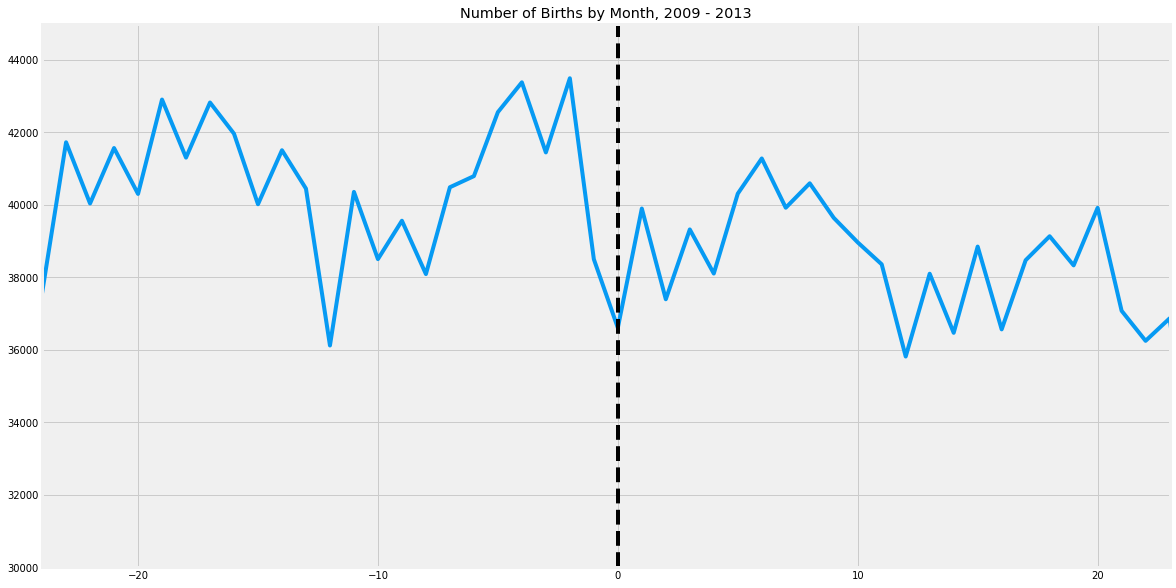

In [65]:
plt.figure(figsize=(18,10))
plt.plot(births_updated.set_index(keys='Month_of_Birth'), color='xkcd:azure')
axes = plt.gca()
axes.set_xlim([-24,23])
axes.set_ylim([30000,45000])
plt.axvline(x=0,color="black", linestyle="--")
plt.title('Number of Births by Month, 2009 - 2013')
plt.show()

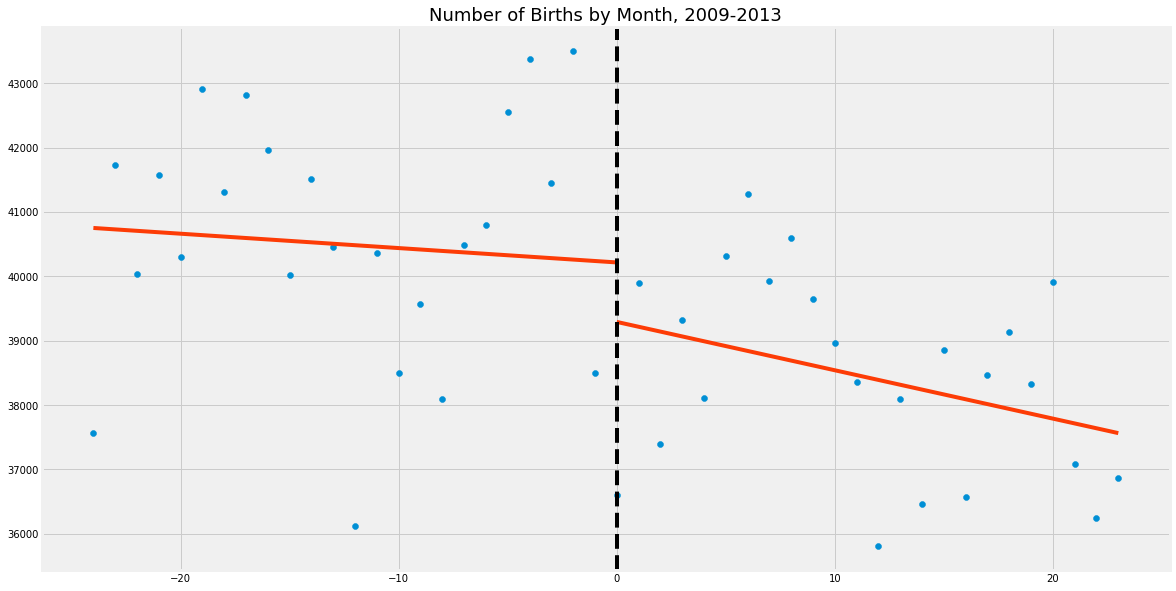

In [66]:
rdd_graph(births_updated['Month_of_Birth'], births_updated['Number_of_Births'],"Number of Births by Month, 2009-2013" )

The first graph shows the number of births by month in the years 2009 – 2013. In the second graph, the regression discontinuity design can be observed and a clear jump around the cutoff can be seen. This shows the influence of the repeal of the policy on births 9 months after the policy was announced.    

In [67]:
#Regressions
def regression_births_updated(start_date, end_date, linear_trend, quad_trend, cubic_trend, month_dummies):
    
    data = births_updated.loc[(births_updated['Month_of_Birth']>start_date) & (births_updated['Month_of_Birth']<end_date)]
    
    x=['Post', 'Days']
    y = data['ln']
    
    if linear_trend == True:
        lt = ['linear_trend', 'postXlinear']
        x += lt
    
    if quad_trend == True:
        qt = ['quad_trend', 'postXquad']
        x += qt
        
    if cubic_trend == True:
        ct = ['cubic_trend', 'postXcubic']
        x += ct
        
    if month_dummies == True:
        md = ['month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
                'month_10','month_11', 'month_12']
        x += md
        
    x = sm.add_constant(data[x])
    model = sm.OLS(y,x).fit(cov_type='HC1')
    
    return model

#### Regression Table for Births

In [68]:
linear_trend = True
quad_trend = False
cubic_trend = False
month_dummies = False

print(regression_births_updated(-12,11, linear_trend, quad_trend, cubic_trend, month_dummies).summary())

                            OLS Regression Results                            
Dep. Variable:                     ln   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     8.513
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           0.000582
Time:                        12:40:56   Log-Likelihood:                 44.784
No. Observations:                  22   AIC:                            -79.57
Df Residuals:                      17   BIC:                            -74.11
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.9322      0.220     45.177   

In [69]:
#List regression parameters
regression_parameters_births = pd.DataFrame

#(Start Period, End Period, Linear Trend, Quadatic Trend, Cubic Trend, Month Controls)
parameters  =[[-31, 30, True, True, True, False], 
             [-25,24, True,True, False, False],
             [-13,12,True,True, False, False],
             [-10,9, True,False, False, False],
             [-6,5, False,False,False, False],
             [-4,3, False,False, False, False], 
             [-31, 30, True, True, True, True],
             [-31, 66, True, True, True, True]
             ]

regression_parameters_births = pd.DataFrame(parameters, columns=['Starting Period', 'Ending Period', 
                                                                 'Linear Trend', 'Quadratic Trend', 'Cubic Trend', 'Month Controls'])

In [70]:
regression_results_births = pd.DataFrame(columns=['Coefficent', 'Standard Error', 'p-value'])

for i in range(8):
    x = regression_parameters_births.iloc[i].tolist()
    results = pd.Series([regression_births_updated(*x).params.Post, 
               regression_births_updated(*x).bse.Post, 
               regression_births_updated(*x).pvalues.Post], index=regression_results_births.columns)
    regression_results_births = regression_results_births.append(results, ignore_index=True)

In [71]:
regression_results_births = pd.concat([regression_results_births.T, regression_parameters_births.T], ignore_index=False)
regression_results_births = regression_results_births.rename(columns={0:'RDD (72 Months)',1:'RDD (48 Months)',2:'RDD (24 Months)',3:'RDD (18 Months)',4:'RDD (12 Months)',
                                                                      5:'RDD (6 Months)', 6:'DID (5 Years)', 7:'DID (8 Years)'})


#### Regression Results for Births

In [72]:
regression_results_births

,RDD (72 Months),RDD (48 Months),RDD (24 Months),RDD (18 Months),RDD (12 Months),RDD (6 Months),DID (5 Years),DID (8 Years)
Coefficent,-0.0520108,-0.0448174,-0.0624621,-0.0931494,-0.0771842,-0.0585997,-0.030211,-0.0115373
Standard Error,0.0558944,0.0416616,0.0661729,0.0518085,0.0238092,0.0426463,0.0420293,0.0409638
p-value,0.352103,0.28204,0.345209,0.0721843,0.00118784,0.169415,0.472259,0.778214
Starting Period,-31,-25,-13,-10,-6,-4,-31,-31
Ending Period,30,24,12,9,5,3,30,66
Linear Trend,True,True,True,True,False,False,True,True
Quadratic Trend,True,True,True,False,False,False,True,True
Cubic Trend,True,False,False,False,False,False,True,True
Month Controls,False,False,False,False,False,False,True,True


We used the same theoretical approach found in the paper, using a regression discontinuity, and a difference-in-differences design, with linear, cubic, and quadratic trend variables and their interaction terms, and monthly fixed effects. We tested six bandwidth values, 6, 12, 18, 24, 48, and 72 months and two different difference-in-differences designs, using 5 years and 8 years. 

While the sign of the coefficient of the treatment effect was negative, as expected, we only found statistically significant results at with the RDD 12, and 18 months. This implies that births decreased between 7% and 9% nine months after the policy announcement. While these results are promising as a first analysis, they don’t seem to be robust.